In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import torch.optim as optim

In [2]:
workers = 8
ngpu = 1
beta1 = 0.5
lr = 0.0002
bs = 60
epochs = 60

path_train_x = "images/train/train_x"
path_train_y = "images/train/train_y"

path_valid_x = "images/valid/valid_x"
path_valid_y = "images/valid/valid_y"

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

imgs_train_x = datasets.ImageFolder(path_train_x, transform = transform)
imgs_train_y = datasets.ImageFolder(path_train_y, transform = transform)

imgs_valid_x = datasets.ImageFolder(path_valid_x, transform = transform)
imgs_valid_y = datasets.ImageFolder(path_valid_y, transform = transform)

In [4]:
print(len(imgs_train_x))
print(len(imgs_train_y))
#imgs_train_x.classes
#train_ds = TensorDataset(imgs_train_x, imgs_train_y)

611
611


In [5]:
imgs_train_x_dl = DataLoader(imgs_train_x, batch_size = bs, num_workers = workers)
imgs_train_y_dl = DataLoader(imgs_train_y, batch_size = bs, num_workers = workers)

imgs_valid_x_dl = DataLoader(imgs_valid_x, batch_size = bs, num_workers = workers)
imgs_valid_y_dl = DataLoader(imgs_valid_y, batch_size = bs, num_workers = workers)

In [6]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [7]:
class SuperResolution(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, kernel_size = 5, padding = 2)
        self.conv2 = nn.Conv2d(6, 12, kernel_size = 5, padding = 2)
        self.upsample = nn.PixelShuffle(upscale_factor = 2)

    def forward(self, xb):
        
        xb = torch.tanh(self.conv1(xb))
        xb = torch.sigmoid(self.conv2(xb))
        
        return self.upsample(xb)

In [8]:
def preprocess(x, y):
    return x.to(device), y.to(device)

In [9]:
def get_model():
    model = SuperResolution().to(device)
    return model, optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

loss_func = nn.MSELoss(reduction='mean')

In [10]:
class WrappedDataLoader:
    def __init__(self, dl_x, dl_y, func):
        assert len(dl_x) == len(dl_y)
        self.dl_x = dl_x
        self.dl_y = dl_y
        self.func = func
    
    def __len__(self):
        return len(self.dl_x)

    def __iter__(self):
        batches_x = iter(self.dl_x)
        batches_y = iter(self.dl_y)
        
        for b_x, _ in batches_x:
            b_y, _ = batches_y.next()
            yield (self.func(b_x, b_y))
        

In [11]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

In [12]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, val_losses):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_losses.append(val_loss)
        
        print(epoch, val_loss)

In [13]:
train_dl = WrappedDataLoader(imgs_train_x_dl, imgs_train_y_dl, preprocess)
valid_dl = WrappedDataLoader(imgs_valid_x_dl, imgs_valid_y_dl, preprocess)

val_losses = []

model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl, val_losses)

0 0.6629274964332581
1 0.5474789381027222
2 0.40716699361801145
3 0.3523054540157318
4 0.3328704297542572
5 0.3197775363922119
6 0.3070660591125488
7 0.29316725730896
8 0.27810372710227965
9 0.26462632417678833
10 0.25599233210086825
11 0.24999066889286042
12 0.2456602305173874
13 0.24261827170848846
14 0.24034341275691987
15 0.23860947787761688
16 0.23723018169403076
17 0.2360895872116089
18 0.2351166933774948
19 0.2342681974172592
20 0.23351492881774902
21 0.23283641040325165
22 0.23221856355667114
23 0.23165178298950195
24 0.23112936913967133
25 0.23064655661582947
26 0.23019976317882537
27 0.22978635132312775
28 0.22940407693386078
29 0.22905104160308837
30 0.2287253648042679
31 0.2284253269433975
32 0.22814912497997283
33 0.22789498269557953
34 0.2276611477136612
35 0.22744590938091278
36 0.22724757790565492
37 0.22706455290317534
38 0.22689538300037385
39 0.22673868834972383
40 0.2265932083129883
41 0.22645775079727173
42 0.22633136510849
43 0.22621306777000427
44 0.2261020481586

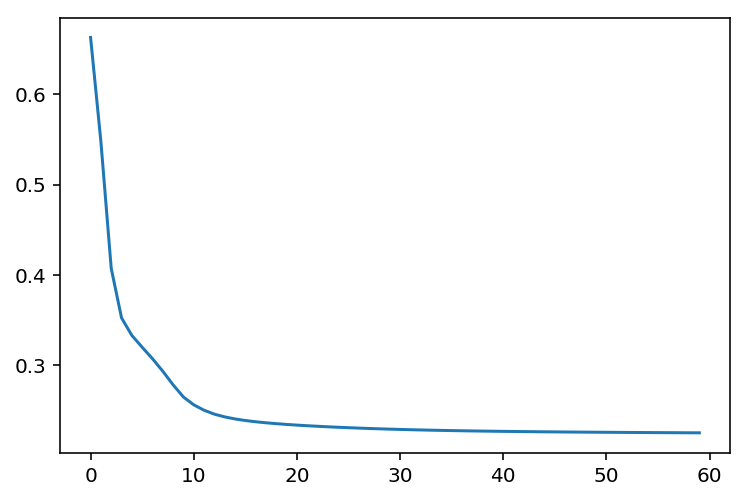

In [14]:
plt.plot(val_losses)
plt.show()

In [15]:
torch.save(model, "SR_model_2.2.ml")

C:\Anaconda3\.conda\envs'\torch_env\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type SuperResolution. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>